In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

from pprint import pprint
import time

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

#use a fixed seed for reproducibility
#seed = np.random.randint(10000, size=1)[0]
#print(seed)
seed = 6016
np.random.seed(seed)


Using TensorFlow backend.


In [2]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
dataframe = pd.read_csv("dump.txt", header=None)
dataset = dataframe.values

num_samples, num_features = dataset.shape
num_features -=1
num_labels=1
print("Samples: %d\nFeatures: %d" % (num_samples, num_features))

y=dataset[:,num_features].astype(float)
print("Histogram: check all 0s and 1s, no -1s etc.")
pprint(np.histogram(y))

X = dataset[:,0:num_features].astype(float)
# split into training, xval, test, 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_xval, X_test, y_xval, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print "Training set"
print X_train.shape
pprint(np.histogram(y_train))

print "Xval set"
print X_xval.shape
pprint(np.histogram(y_xval))

print "Test set"
print X_test.shape
pprint(np.histogram(y_test))


Loading data...
Samples: 59800
Features: 869
Histogram: check all 0s and 1s, no -1s etc.
(array([57380,     0,     0,     0,     0,     0,     0,     0,     0,  2420]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Training set
(35880, 869)
(array([34431,     0,     0,     0,     0,     0,     0,     0,     0,  1449]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Xval set
(11960, 869)
(array([11451,     0,     0,     0,     0,     0,     0,     0,     0,   509]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Test set
(11960, 869)
(array([11498,     0,     0,     0,     0,     0,     0,     0,     0,   462]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


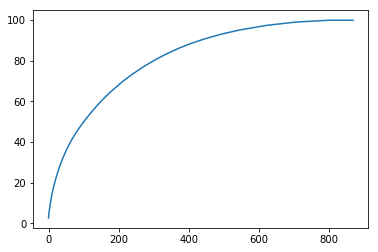

In [3]:
#scree chart to see how much variation is explained by how many predictors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

pca = PCA(n_components=869)
pca.fit(X_train)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)
%matplotlib inline
plt.plot(var1)

# looks like ~100 orthogonal PCA components explain > 50% of the variation

In [4]:
# For a custom f-score metric
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def recall(y_true, y_pred):
    # return keras tensor for recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    # return keras tensor for precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f_score(y_true, y_pred):
    beta = 2 # penalize false positives
    return fbeta_score(y_true, y_pred, beta=2)
    #my_precision = precision(y_true, y_pred)
    #my_recall = recall(y_true, y_pred)
    
    #f_score = (1 +( beta **2)) * my_precision * my_recall / ((beta ** 2) * my_precision + my_recall)

#def my_score(estimator, X, y):
#    predict y_pred using X
##    error_score = false_pos * 2 + false_neg 
#    if error_score > len(X) return 0
#    else return 1 - error_score/len(X)


# function to generate model
def create_model(hidden_layer_size=30, dropout=(2.0/3.0), reg_penalty=0.0001):
    # create model
    model = Sequential()
    model.add(Dense(hidden_layer_size, 
                    input_dim=869, 
                    kernel_initializer='normal', 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(reg_penalty)
                   ))
    model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f_score])
    return model

def selectThreshold (logits, labels, beta=1):
    # return threshold, f-score that yields best F-score
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    f1_scores = (1 +( beta **2)) * precision * recall / ((beta ** 2) * precision + recall)
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)



In [7]:
print('%s Starting' % time.strftime("%H:%M:%S"))

# minimize a raw score
# show correct metric
# pick threshold using correct metric

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=100, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

hidden_layer_hp = [10, 20, 30]
dropout_hp = [0.333, 0.5, 0.667]
reg_penalty_hp = [0.00001, 0.0001, 0.001]
class_weight1= {0: 1.0, 1: 1.0}
class_weight2= {0: 1.0, 1: 2.0}
class_weight3 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight_hp = [class_weight1, class_weight2, class_weight3]

param_grid = dict(hidden_layer_size=hidden_layer_hp, 
                  dropout=dropout_hp, 
                  reg_penalty=reg_penalty_hp,
                  class_weight=class_weight_hp)

#grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold, n_jobs=-1)
#classifier = grid.fit(X_train, y_train)

#GridSearchCV is annoying to use with custom metric to choose best, sted accuracy
#would like to do k-fold CV and average raw error but not clear how to do that
#also would like output after each iteration

for hl in hidden_layer_hp:
    for dr in dropout_hp:
        for rp in reg_penalty_hp:
            count=0
            for cw in class_weight_hp:
                count+=1
                print("\n%s Hidden layer: %d, Dropout: %.4f, Regularization %.8f, class weight: %d" % 
                      (time.strftime("%H:%M:%S"), hl, dr, rp, count))               
                classifier = KerasClassifier(build_fn=create_model, epochs=100, batch_size=100, verbose=0,
#                                        cv=kfold,
                                        hidden_layer_size=hl, 
                                        dropout=dr, 
                                        reg_penalty=rp,
                                        class_weight=cw
                                       )
                classifier.fit(X_train, y_train)
                                
                y_xval_proba = classifier.predict_proba(X_xval)[:,1]
                thresh, score = selectThreshold(y_xval_proba, y_xval, beta=(2.0/3))
                y_xval_pred = y_xval_proba >= thresh
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                true_negatives = confusion_matrix[0][0]
                false_negatives = confusion_matrix[0][1]
                false_positives = confusion_matrix[1][0]
                true_positives = confusion_matrix[1][1]
                total_observations = len(y_xval_pred)
                
                print("Xval f-score %.3f" % score)
                print("Xval F1 %.3f" % sklearn.metrics.f1_score(y_xval_pred, y_xval))
                print("Raw error score ----------> %.4f" % ((false_positives*2 + false_negatives) / float(total_observations)))                

print('%s Finishing' % time.strftime("%H:%M:%S"))

# summarize results
# print("Best: %f using %s" % (classifier.best_score_, classifier.best_params_))
# means = classifier.cv_results_['mean_test_score']
# stds = classifier.cv_results_['std_test_score']
# params = classifier.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, X_train, y_train, cv=kfold)
#print("\nResults: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


18:37:33 Starting

18:37:33 Hidden layer: 10, Dropout: 0.3330, Regularization 0.00000000, class weight: 1
[[11345   248]
 [  106   261]]
Xval f-score 0.636
Xval F1 0.596
Raw error score ----------> 0.0385

18:38:40 Hidden layer: 10, Dropout: 0.3330, Regularization 0.00000000, class weight: 2
[[11323   209]
 [  128   300]]
Xval f-score 0.662
Xval F1 0.640
Raw error score ----------> 0.0389

18:39:48 Hidden layer: 10, Dropout: 0.3330, Regularization 0.00000000, class weight: 3
[[11371   234]
 [   80   275]]
Xval f-score 0.683
Xval F1 0.637
Raw error score ----------> 0.0329

18:40:55 Hidden layer: 10, Dropout: 0.3330, Regularization 0.00001000, class weight: 1
[[11376   220]
 [   75   289]]
Xval f-score 0.707
Xval F1 0.662
Raw error score ----------> 0.0309

18:42:03 Hidden layer: 10, Dropout: 0.3330, Regularization 0.00001000, class weight: 2
[[11379   246]
 [   72   263]]
Xval f-score 0.677
Xval F1 0.623
Raw error score ----------> 0.0326

18:43:13 Hidden layer: 10, Dropout: 0.3330, Re

[[11393   252]
 [   58   257]]
Xval f-score 0.686
Xval F1 0.624
Raw error score ----------> 0.0308

19:34:55 Hidden layer: 20, Dropout: 0.6670, Regularization 0.00000000, class weight: 1
[[11348   219]
 [  103   290]]
Xval f-score 0.676
Xval F1 0.643
Raw error score ----------> 0.0355

19:36:16 Hidden layer: 20, Dropout: 0.6670, Regularization 0.00000000, class weight: 2
[[11361   227]
 [   90   282]]
Xval f-score 0.681
Xval F1 0.640
Raw error score ----------> 0.0340

19:37:38 Hidden layer: 20, Dropout: 0.6670, Regularization 0.00000000, class weight: 3
[[11385   244]
 [   66   265]]
Xval f-score 0.687
Xval F1 0.631
Raw error score ----------> 0.0314

19:39:00 Hidden layer: 20, Dropout: 0.6670, Regularization 0.00001000, class weight: 1
[[11383   233]
 [   68   276]]
Xval f-score 0.699
Xval F1 0.647
Raw error score ----------> 0.0309

19:40:32 Hidden layer: 20, Dropout: 0.6670, Regularization 0.00001000, class weight: 2
[[11367   218]
 [   84   291]]
Xval f-score 0.699
Xval F1 0.658
R

In [10]:
# select preferred parameters using raw error and f-score

hl = 20
dr = 0.6670
rp = 0.00010000
cw = {0: 1.0, 1: 1.0}

classifier = KerasClassifier(build_fn=create_model, epochs=300, batch_size=500, verbose=0,
                             hidden_layer_size=hl, 
                             dropout=dr, 
                             reg_penalty=rp,
                             class_weight=cw
                             )
classifier.fit(X_train, y_train)

y_xval_proba = classifier.predict_proba(X_xval)[:,1]
thresh, score = selectThreshold(y_xval_proba, y_xval, beta=(2.0/3))
y_xval_pred = y_xval_proba >= thresh

confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
print(confusion_matrix)
true_negatives = confusion_matrix[0][0]
false_negatives = confusion_matrix[0][1]
false_positives = confusion_matrix[1][0]
true_positives = confusion_matrix[1][1]
total_observations = len(y_xval_pred)
                
print("Xval f-score %.3f" % score)
print("Xval F1 %.3f" % sklearn.metrics.f1_score(y_xval_pred, y_xval))
print("Raw error score ----------> %.4f" % ((false_positives*2 + false_negatives) / float(total_observations)))                

y_test_proba = classifier.predict_proba(X_test)[:,1]
thresh, score = selectThreshold(y_test_proba, y_test, beta=(2.0/3))
y_test_pred = y_test_proba >= thresh

confusion_matrix = sklearn.metrics.confusion_matrix(y_test_pred, y_test)
print(confusion_matrix)
true_negatives = confusion_matrix[0][0]
false_negatives = confusion_matrix[0][1]
false_positives = confusion_matrix[1][0]
true_positives = confusion_matrix[1][1]
total_observations = len(y_test_pred)

print("Test f-score %.3f" % score)
print("Test F1 %.3f" % sklearn.metrics.f1_score(y_test_pred, y_test))
print("Raw error score ----------> %.4f" % ((false_positives*2 + false_negatives) / float(total_observations)))                



[[11385   232]
 [   66   277]]
Xval f-score 0.703
Xval F1 0.650
Raw error score ----------> 0.0304
[[11412   214]
 [   86   248]]
Test f-score 0.664
Test F1 0.623
Raw error score ----------> 0.0323
